In [2]:
!pip install faiss-cpu

In [3]:
!pip install rouge

In [4]:
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import spacy
import faiss
from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration, RagSequenceForGeneration
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import copy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /home/pranit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/pranit/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/pranit/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
2024-05-06 22:29:35.476933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: li

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [5]:
import os
import json
from tqdm import tqdm  # Use tqdm.notebook for Jupyter compatibility
i = 0
# Specify the directory containing your JSON files
directory_path = './searchqa-val'

# Initialize an empty list to store the data from individual files
combined_data_val = []

# Get the list of JSON files in the directory
json_files = [filename for filename in os.listdir(directory_path) if filename.endswith('.json')]

# Use tqdm.notebook to display a progress bar in Jupyter notebook
for filename in tqdm(json_files, desc='Reading JSON files', unit='file'):
    file_path = os.path.join(directory_path, filename)
    
    # Read data from each file and append it to the combined_data_val list
    with open(file_path, 'r') as file:
        file_data = json.load(file)
        combined_data_val.append(file_data)
        i += 1
    if(i == 21613):
        print("read all")
    elif(i == 21612):
        print("Almost read all")
print("read")
# Now, combined_data_val contains the data from all JSON files in the specified directory
# print(combined_data_val)


Reading JSON files: 100%|██████████| 21613/21613 [00:05<00:00, 4250.31file/s]

Almost read all
read all
read


In [6]:
import os
import json
from tqdm import tqdm  # Use tqdm.notebook for Jupyter compatibility
i = 0
# Specify the directory containing your JSON files
directory_path = './searchqa-test'

# Initialize an empty list to store the data from individual files
combined_data_test = []

# Get the list of JSON files in the directory
json_files = [filename for filename in os.listdir(directory_path) if filename.endswith('.json')]

# Use tqdm.notebook to display a progress bar in Jupyter notebook
for filename in tqdm(json_files, desc='Reading JSON files', unit='file'):
    file_path = os.path.join(directory_path, filename)
    
    # Read data from each file and append it to the combined_data_test list
    with open(file_path, 'r') as file:
        file_data = json.load(file)
        combined_data_test.append(file_data)
        i += 1
    if(i == 21613):
        print("read all")
    elif(i == 21612):
        print("Almost read all")
print("read")
# Now, combined_data_test contains the data from all JSON files in the specified directory
# print(combined_data_test)


Reading JSON files:  52%|█████▏    | 22479/43228 [00:04<00:04, 4561.27file/s]

Almost read all
read all


Reading JSON files: 100%|██████████| 43228/43228 [00:09<00:00, 4554.14file/s]

read


In [7]:
print(len(combined_data_val))
print(len(combined_data_test))

21613
43228


In [8]:
len(combined_data_val[2]['search_results'][0]['snippet'].strip().split())

26

In [9]:
combined_data_val[2]

{'category': 'TREATS',
 'search_results': [{'url': '/url?q=http://www.countryliving.com/food-drinks/g764/easy-summer-desserts-0409/&sa=U&ved=0ahUKEwi3iJbV54XQAhXBMyYKHcSvAkUQFggZMAE&usg=AFQjCNHvrRGkc0DEfEVK-HkbRPFzGaKZiA',
   'snippet': "May 11, 2016 ... 50 Easy Summer Desserts That Don't Require an Oven. Because it's hot enough \nalready without turning the oven on. Created with Sketch.",
   'related_links': None,
   'title': '50 Easy Summer Desserts - Best Recipes for Frozen Summer ...'},
  {'url': '/url?q=https://www.pinterest.com/explore/summer-desserts/&sa=U&ved=0ahUKEwi3iJbV54XQAhXBMyYKHcSvAkUQFggeMAI&usg=AFQjCNEOi-RWaB5bGtiRPRmSBri8DSN5NA',
   'snippet': 'This quick and easy Lemon Raspberry Poke Cake will be your next favorite \nsummer cake. Poke cakes make a great potluck dessert. This poke cake is a \nlemon...',
   'related_links': None,
   'title': '1000+ ideas about Summer Desserts on Pinterest | Desserts, Easy ...'},
  {'url': '/url?q=https://www.facebook.com/mybakingaddict

In [10]:
from collections import defaultdict

BASIC_ANALYSIS

In [11]:
def print_basic_analysis(data):
    d = defaultdict(lambda: 0)
    vocabulary = defaultdict(lambda: 0)
    j = len(data)
    for i in range(j):
        k = len(data[i]['answer'].split())
        d[k] += 1
    print("Number of examples are: ", len(data))
    print("Number of unigram answers is: ", d[1])
    print("Percentage of unigram answers: ", d[1] / sum(d.values()))
    average_snippets = 0
    average_snippets_length = 0
    for i in range(j):
        current_length = len(data[i]['search_results'])
        for k in range(current_length):
            if(data[i]['search_results'][k]['snippet'] is not None and len(data[i]['search_results'][k]['snippet']) > 0):
                average_snippets += 1
                average_snippets_length += len(data[i]['search_results'][k]['snippet'].split())
    average_snippets_length = average_snippets_length / average_snippets
    average_snippets = average_snippets / sum(d.values())
    print("Number of average snippets: ", average_snippets)
    print("Average snippet length(split on whitespace): ", average_snippets_length)
    average_answer_length = 0
    for key in d.keys():
        average_answer_length += key * d[key]
    average_answer_length = average_answer_length / sum(d.values())
    print("Average answer length: ", average_answer_length)

In [12]:
print_basic_analysis(combined_data_val)

Number of examples are:  21613
Number of unigram answers is:  9317
Percentage of unigram answers:  0.43108314440383105
Number of average snippets:  63.00601489844075
Average snippet length(split on whitespace):  50.158391891604104
Average answer length:  1.8846990237357146


In [13]:
print_basic_analysis(combined_data_test)

Number of examples are:  43228
Number of unigram answers is:  18698
Percentage of unigram answers:  0.4325437216618858
Number of average snippets:  62.890510780049965
Average snippet length(split on whitespace):  49.48185097573006
Average answer length:  1.869436476357916


In [14]:
# Open the JSONL file
eli5 = []
with open('ELI5-001.jsonl', 'r') as f:
    # Read each line (JSON object) in the file
    for line in tqdm(f):
        # Parse JSON object
        eli5.append(json.loads(line))
        # Process the JSON data as needed
    print(len(eli5))  # Example: print the JSON data


272634it [00:12, 22085.00it/s]

272634


In [ ]:
# eli5[0]

In [15]:
def getnumberofwords(text):
    # return len(text.split())
    return len(word_tokenize(text))

In [16]:
def eli5_analysis():
    j = len(eli5)
    answer_lengths = 0
    number_of_answers = 0
    question_lengths = 0
    question_lengths_list = []
    for i in tqdm(range(j)):
        question_lengths_list.append(getnumberofwords(eli5[i]['question']))
        question_lengths += getnumberofwords(eli5[i]['question'])
        j2 = len(eli5[i]['answers'])
        for i2 in range(j2):
            answer_lengths += getnumberofwords(eli5[i]['answers'][i2])
            number_of_answers += 1
    print("Average number of words in questions: ", question_lengths / j)
    print("Average number of words in answers: ", answer_lengths / number_of_answers)

    plt.hist(question_lengths_list, bins=50, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.grid(True)
    plt.show()

    

100%|██████████| 272634/272634 [05:45<00:00, 789.52it/s] 


Average number of words in questions:  15.781182831194934
Average number of words in answers:  121.65526183621003


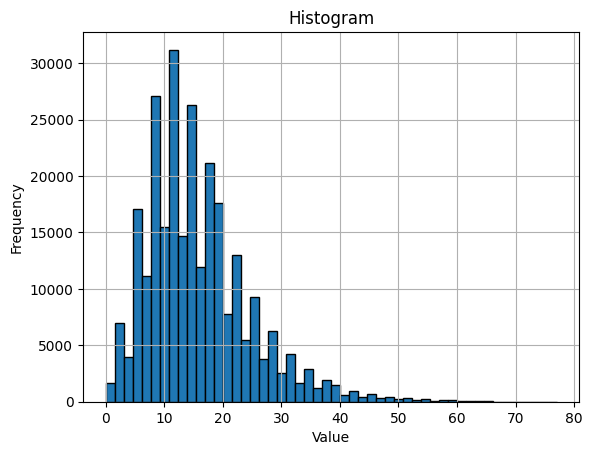

In [17]:
eli5_analysis()

In [18]:
i = 1
print(eli5[i]['question'])
print(getnumberofwords(eli5[i]['question']))

Why are different tiers (regular < mid < premium) of gas' prices almost always 10 cents different?
21


In [6]:
def load_model(type_of_model, dataset, dummy_dataset = True):
    if(dataset == "nq"):
        if(type_of_model == "token"):
            tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-nq")
            retriever = RagRetriever.from_pretrained("facebook/rag-token-nq", index_name="exact", use_dummy_dataset=dummy_dataset)
            model = RagTokenForGeneration.from_pretrained("facebook/rag-token-nq", retriever=retriever)
        elif(type_of_model == "sequence"):
            tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-nq") 
            retriever = RagRetriever.from_pretrained("facebook/rag-sequence-nq", index_name="exact", use_dummy_dataset=dummy_dataset) 
            model = RagSequenceForGeneration.from_pretrained("facebook/rag-sequence-nq", retriever=retriever) 
        else:
            print("Please enter a valid type of model")
            return None, None, None
        return tokenizer, retriever, model 
    else:
        if(type_of_model == "token"):
            tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-base")
            retriever = RagRetriever.from_pretrained("facebook/rag-token-base", index_name="exact", use_dummy_dataset=dummy_dataset)
            model = RagTokenForGeneration.from_pretrained("facebook/rag-token-base", retriever=retriever)
        elif(type_of_model == "sequence"):
            tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-base") 
            retriever = RagRetriever.from_pretrained("facebook/rag-sequence-base", index_name="exact", use_dummy_dataset=dummy_dataset) 
            model = RagSequenceForGeneration.from_pretrained("facebook/rag-sequence-base", retriever=retriever) 
        else:
            print("Please enter a valid type of model")
            return None, None, None
        return tokenizer, retriever, model 

In [7]:
tokenizer_token, retriever_token, model_token = load_model("token", "base")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

In [19]:
tokenizer_sequence, retriever_sequence, model_sequence = load_model("sequence", "nq")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

In [17]:
def generate(input, tokenizer, retreiver, model, max_length=10, num_beams = 4, temperature=1):
    input_dict = tokenizer.__call__(input, return_tensors="pt") 
    # print(input_dict)
    generated = model.generate(
    input_ids=input_dict["input_ids"],
    max_length=max_length,  # Set maximum length of generated text
    num_beams=num_beams,    # Use beam search with 4 beams for generation
    temperature=temperature # Use temperature scaling for diverse outputs
    )
    # print("Hello")
    # print(generated)
    # print("Hello")
    return tokenizer.batch_decode(generated, skip_special_tokens=True)[0] 

In [ ]:
def generate2(input, label_text, tokenizer, retreiver, model, max_length=100, num_beams = 4, temperature=1):
    input_dict = tokenizer.__call__(input, return_tensors="pt") 
    label_dict = tokenizer.__call__(label_text, return_tensors="pt") 
    input_ids=input_dict["input_ids"]
    labels = label_dict["input_ids"]
    print(input_ids)
    print(input_ids.shape)
    generated2 = model.forward(input_ids, num_beams = num_beams, max_length = max_length, do_marginalize = True, labels = labels)
    print(generated2)
    print(generated2.logits.shape)
    print(generated2.loss)

In [ ]:
generate2('what is the name of the most important jewish text', 'the Shulchan Aruch', tokenizer_token, retriever_token, model_token)

In [22]:
generate("name a country", tokenizer_sequence, retriever_sequence, model_sequence)

' islamic republic of afghanistan'

In [23]:

# Replace 'file_path.parquet' with the path to your Parquet file
file_path = 'train-00000-of-00287.parquet'
### only a part of nq dataset as the whole dataset was taking too much time for me  
### so i started downloading the dataset manually 

# Read the Parquet file into a DataFrame
df = pd.read_parquet(file_path)
print(df.iloc[5]['question']['text'])
print(df.iloc[5]["annotations"]['short_answers'][0]['text'])

how many nominations does game of thrones have
[]


In [24]:
rows = []
for i in range(len(df)):
    if(len(df.iloc[i]["annotations"]['short_answers'][0]['text']) > 0):
        rows.append(i)
df2 = df.iloc[rows]

In [25]:
i = 2
print(df2.iloc[i]['question']['text'])
print(df2.iloc[i]["annotations"]['short_answers'][0]['text'])

what is the name of the most important jewish text
['the Shulchan Aruch']


In [26]:
df.iloc[0]["annotations"]['short_answers'][0]['text'][0]

'March 18, 2018'

In [27]:
df.iloc[0].keys()

Index(['id', 'document', 'question', 'long_answer_candidates', 'annotations'], dtype='object')

In [28]:
maximum = 0
for i in range(len(df2)):
    if(len(df2.iloc[i]["annotations"]['short_answers'][0]['text'][0].split()) > maximum):
        maximum = len(df2.iloc[i]["annotations"]['short_answers'][0]['text'][0].split())
print(maximum)

131


In [29]:
print(df2.iloc[i]["annotations"]['short_answers'][0]['text'][0])
print(df2.iloc[i]['question']['text'])

ASCII
is an encoding for english alphanumeric characters as 7-bit numbers


In [30]:
from rouge import Rouge

score_list = []
# Initialize Rouge
rouge = Rouge()

# Example reference summary and system summary
for i in tqdm(range(len(df2))):
    reference_summary = df2.iloc[i]["annotations"]['short_answers'][0]['text'][0]
    system_summary = generate(df2.iloc[i]['question']['text'], tokenizer_token, retriever_token, model_token, max_length = 3)
    reference_summary = reference_summary.lower()
    system_summary = system_summary.lower()
    if(len(reference_summary) == 0 or len(system_summary) == 0):
        continue
    # print(type(reference_summary))
    # print(type(system_summary))
    # print(reference_summary)
    # print(system_summary)
    # Calculate ROUGE scores
    scores = rouge.get_scores(system_summary, reference_summary)
    score_list.append(scores)

# Print ROUGE scores
print(scores)

  0%|          | 0/362 [00:00<?, ?it/s]/home/pranit/.local/lib/python3.9/site-packages/transformers/generation/utils.py:2949: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(
  2%|▏         | 8/362 [00:20<15:10,  2.57s/it]


KeyboardInterrupt: 

In [31]:
score_list[0][0]

{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}

In [32]:
j = len(score_list)
score_list2 = []
for i in range(j):
    score_list2.append(score_list[i][0]['rouge-1']['f'])
print(max(score_list2))
print(sum(score_list2) / len(score_list2))

0.4999999962500001
0.06249999953125001


In [33]:
model_token.rag.generator.lm_head

Linear(in_features=1024, out_features=50265, bias=False)

In [34]:
class QAModel(nn.Module):
    def __init__(self, model):
        super(QAModel, self).__init__()
        qa_model = copy.deepcopy(model)
        qa_model.rag.generator.lm_head = nn.Identity()
        qa_model.rag.generator.lm_head = nn.Linear(1024, 50265)
        for param in qa_model.parameters():
            param.requires_grad = False
        for param in qa_model.rag.generator.lm_head.parameters():
            param.requires_grad = True
        self.qa_model = qa_model
    
    def forward(self, x):
        x = self.qa_model.__call__(input_ids=x)
        return x

In [35]:
qa_model = QAModel(model_token)

In [36]:
def tokenize(sentences):
    tokenized = []
    for sentence in tqdm(sentences):
        tokenized.append(word_tokenize(sentence))
    return tokenized

In [37]:
vocabulary = tokenizer_token.generator.get_vocab()
def convert_tokens_to_numbers(tokenized_sentences):
    tokenized_sentences_in_numbers = []
    for sentence in tqdm(tokenized_sentences):
        temp = []
        for token in sentence:
            temp.append(vocabulary[token])
        tokenized_sentences_in_numbers.append(temp)
    return tokenized_sentences_in_numbers

In [38]:
print(type(vocabulary))

<class 'dict'>


In [39]:
input_dict = tokenizer_token.__call__("Hello how are you", return_tensors="pt")
print(input_dict) 

{'input_ids': tensor([[ 101, 7592, 2129, 2024, 2017,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [40]:
class QADataset(Dataset):
    def __init__(self, df2, tokenizer):
        super(QADataset, self).__init__()
        j = len(df2)
        questions = []
        answers = []
        for i in range(j):
            questions.append((tokenizer.__call__(df2.iloc[i]['question']['text'], return_tensors = "pt")["input_ids"])[0])
            answers.append((tokenizer.__call__(df2.iloc[i]["annotations"]['short_answers'][0]['text'][0], return_tensors = "pt")["input_ids"])[0])
            # questions.append(df2.iloc[i]['question']['text'])
            # answers.append(df2.iloc[i]["annotations"]['short_answers'][0]['text'][0])
        self.questions_in_numbers = copy.deepcopy(questions)
        self.answers_in_numbers = copy.deepcopy(answers)
        self.x = []
        self.y = []
        j = len(self.questions_in_numbers)
        for i in range(j):
            self.x.append(torch.tensor(self.questions_in_numbers[i]))
            self.y.append(torch.tensor(self.answers_in_numbers[i]))
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
                

In [41]:
qa_dataset = QADataset(df2, tokenizer_token)
qa_dataloader = DataLoader(qa_dataset, 1, shuffle = True)


/tmp/ipykernel_14390/2397817201.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x.append(torch.tensor(self.questions_in_numbers[i]))
/tmp/ipykernel_14390/2397817201.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y.append(torch.tensor(self.answers_in_numbers[i]))


In [42]:
qa_dataset[2]

(tensor([ 101, 2054, 2003, 1996, 2171, 1997, 1996, 2087, 2590, 3644, 3793,  102]),
 tensor([  101,  1996, 18454, 29358,  2319, 12098, 10875,   102]))

In [45]:
optimizer = torch.optim.Adam(qa_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = -100)
for epoch_num in range(1):
    train_loss = []
    for batch_num, (inputs, targets) in tqdm(enumerate(qa_dataloader)):
        print(targets.shape)
        print(inputs.shape)
        # print(inputs)
        inputs = inputs.to(device)
        targets = targets.float().to(device)
        pred = qa_model(inputs)
        logits = pred.logits.float().to(device)
        print(logits.shape)
        print(logits)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if batch_num % 4000 == 0:
            # print loss every 2 steps
            mean_loss = sum(train_loss) / len(train_loss)
            print(f"{batch_num=}, {mean_loss=}")
            train_loss = []
            torch.save(qa_model, "qa_model")
### DO 2 and 3 again

0it [00:00, ?it/s]

torch.Size([1, 7])
torch.Size([1, 11])


0it [00:03, ?it/s]

torch.Size([5, 300, 50265])
tensor([[[ 0.0791,  0.6174, -0.5041,  ..., -0.6006,  0.0599,  0.3395],
         [ 0.0791,  0.6174, -0.5041,  ..., -0.6006,  0.0599,  0.3395],
         [-0.4396, -0.8913,  0.1469,  ..., -0.2806, -0.2915,  0.1102],
         ...,
         [-0.6243,  0.8446,  0.1960,  ..., -1.8605,  0.6761, -0.3609],
         [-0.6419,  0.9009,  0.1885,  ..., -1.8621,  0.6936, -0.3391],
         [-0.6743,  0.9459,  0.1845,  ..., -1.9320,  0.7261, -0.3466]],

        [[ 0.0295,  0.9630, -0.6751,  ..., -0.7132,  0.0303,  0.4359],
         [ 0.0295,  0.9629, -0.6751,  ..., -0.7132,  0.0303,  0.4359],
         [ 0.1505,  0.1875,  0.4777,  ..., -0.5575, -0.4973, -0.5867],
         ...,
         [-0.5964,  1.3728,  0.1142,  ..., -1.5648,  0.7117, -0.5075],
         [-0.6158,  1.3713,  0.0941,  ..., -1.6161,  0.6649, -0.4368],
         [-0.7056,  1.3956,  0.0381,  ..., -1.7079,  0.5516, -0.4281]],

        [[ 0.0828,  0.6782, -0.7357,  ..., -0.3253,  0.3738,  0.4118],
         [ 0.0828

ValueError: Expected input batch_size (5) to match target batch_size (1).